# gray-WDLAW


Performing 8385 comparisons...


  0%|                                                  | 0/8385 [00:00<?, ?it/s]/var/folders/t0/41mc6_f92_1dlss5hsmd78bh0000gn/T/ipykernel_73338/1840295278.py:60: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  avg_win_energy[:, :, window_idx] = filters.uniform_filter(energy, window_size, mode='constant')
100%|██████████████████████████████████████| 8385/8385 [00:37<00:00, 223.38it/s]


Average Fingerprint Extraction Time: 0.5019 sec per image
Average Comparison Time: 0.0012 sec per comparison


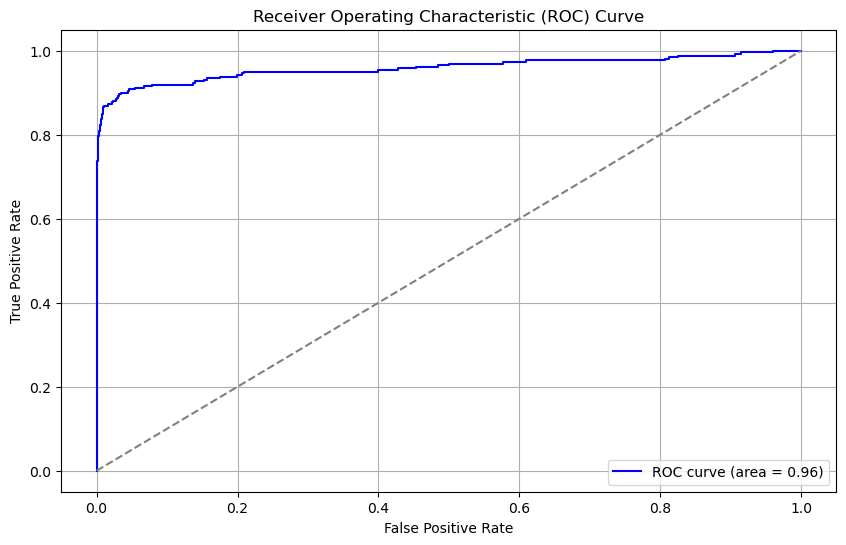

AUC: 0.9587
TPR (Optimal): 0.9000
TNR (Optimal): 0.9660
Optimal Threshold: 0.0024
TPR (TNR = 0.99): 0.8654
Threshold (TNR = 0.99): 0.0032
Total execution time: 37.779s


In [1]:
import pywt 
import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import filters
from scipy.fftpack import fft2, ifft2

spns_dir = Path("/Users/x.l.t./Downloads/CF_project/sub_Dresden")

memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:
    
    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))
    energy = x ** 2
    avg_win_energy = np.zeros(x.shape + (len(window_size_list),))
    
    for window_idx, window_size in enumerate(window_size_list):
        avg_win_energy[:, :, window_idx] = filters.uniform_filter(energy, window_size, mode='constant')
    
    coef_var = threshold(avg_win_energy, noise_var)
    coef_var_min = np.min(coef_var, axis=2)

    x = x * noise_var / (coef_var_min + noise_var)
    
    return x

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:
    
    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2


def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:
    
    noise_var = sigma ** 2
    h, w = im.shape
    
    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)
    
    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0
    
    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))
    
    return im_noise_filt.astype(np.float32)


@memory.cache
def get_wave_components(image_path: Path, levels: int = 4, crop_size=1024, noise_var: float = 1.8**2):
    
    start_time = time.time()

    image = Image.open(image_path)
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)

    # Convert to grayscale
    if len(image_array.shape) == 3:
        image_array = 0.2989 * image_array[:, :, 0] + 0.5870 * image_array[:, :, 1] + 0.1140 * image_array[:, :, 2]  # Luminance formula
    
    coeffs = pywt.wavedec2(image_array, 'db4', level=levels)

    fingerprints = []
    for level in range(1, levels + 1):
        cH, cV, cD = coeffs[level]
        cH_filt = wiener_adaptive(cH, noise_var)
        cV_filt = wiener_adaptive(cV, noise_var)
        cD_filt = wiener_adaptive(cD, noise_var)
        
        cH_filt2 = wiener_dft(cH_filt, np.std(cH_filt))
        cV_filt2 = wiener_dft(cV_filt, np.std(cV_filt))
        cD_filt2 = wiener_dft(cD_filt, np.std(cD_filt))
        
        fingerprints.extend([cH_filt2.flatten(), cV_filt2.flatten(), cD_filt2.flatten()])

    fingerprints = np.concatenate(fingerprints)

    end_time = time.time()
    extraction_time = end_time - start_time

    return fingerprints, extraction_time

@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):
    """
    Computes cosine similarity between two images and tracks comparison time.
    """
    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()
    
    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    df = pd.DataFrame({
        'device_id_1': pd.Series(dtype='str'),
        'image_id_1': pd.Series(dtype='str'),
        'device_id_2': pd.Series(dtype='str'),
        'image_id_2': pd.Series(dtype='str'),
        'similarity': pd.Series(dtype='float'),
        'extraction_time': pd.Series(dtype='float'),
        'comparison_time': pd.Series(dtype='float')
    })

    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    def compute_pairwise_similarity(i, a, j, b):
        similarity, extraction_time, comparison_time = calculate_cosine_similarity(a.spn_path(), b.spn_path())
        return {
            'device_id_1': a.device_id,
            'image_id_1': a.image_id,
            'device_id_2': b.device_id,
            'image_id_2': b.image_id,
            'similarity': similarity,
            'extraction_time': extraction_time,
            'comparison_time': comparison_time
        }

    rows = []
    with ThreadPoolExecutor(max_workers=2) as executor:
        futures = [
            executor.submit(compute_pairwise_similarity, i, a, j, b)
            for i, a in enumerate(image_data_list)
            for j, b in enumerate(image_data_list[i + 1:], start=i + 1)
        ]
        for future in tqdm(as_completed(futures), total=total_comparisons):
            row = future.result()
            rows.append(row)

    df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
    return df

def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()
    
    avg_extraction_time = df['extraction_time'].mean()
    avg_comparison_time = df['comparison_time'].mean()
    
    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")
    
    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.3f}s')


if __name__ == '__main__':
    main()


# rgb-WDLAW

Performing 8385 comparisons...


  0%|                                                  | 0/8385 [00:00<?, ?it/s]/var/folders/t0/41mc6_f92_1dlss5hsmd78bh0000gn/T/ipykernel_73338/2383823587.py:62: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  avg_win_energy[:, :, window_idx] = filters.uniform_filter(energy, window_size, mode='constant')
100%|███████████████████████████████████████| 8385/8385 [01:30<00:00, 93.07it/s]


Average Fingerprint Extraction Time: 1.2651 sec per image
Average Comparison Time: 0.0044 sec per comparison


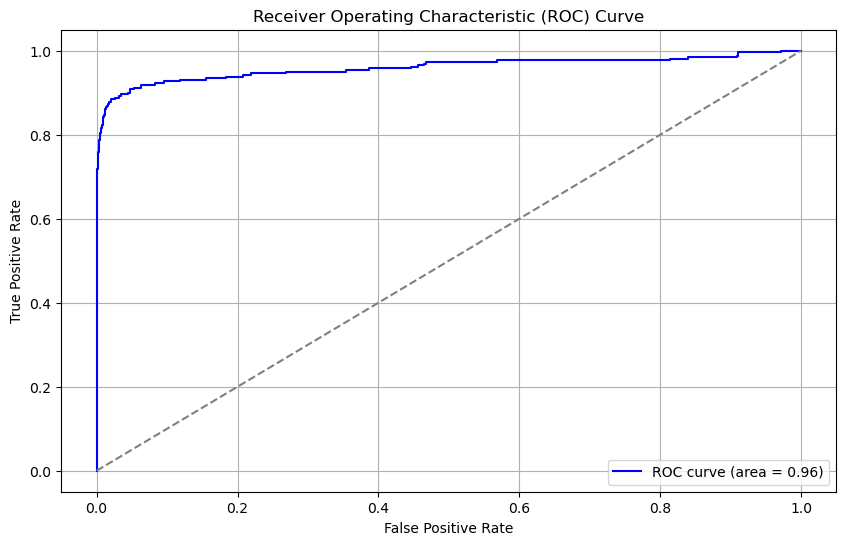

AUC: 0.9594
TPR (Optimal): 0.8846
TNR (Optimal): 0.9796
Optimal Threshold: 0.0026
TPR (TNR = 0.99): 0.8423
Threshold (TNR = 0.99): 0.0031
Total execution time: 90.353s


In [2]:
import pywt  
import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import filters
from scipy.fftpack import fft2, ifft2

spns_dir = Path("/Users/x.l.t./Downloads/CF_project/sub_Dresden")

memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:
    
    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))
    energy = x ** 2
    avg_win_energy = np.zeros(x.shape + (len(window_size_list),))
    
    for window_idx, window_size in enumerate(window_size_list):
        avg_win_energy[:, :, window_idx] = filters.uniform_filter(energy, window_size, mode='constant')
    
    coef_var = threshold(avg_win_energy, noise_var)
    coef_var_min = np.min(coef_var, axis=2)

    x = x * noise_var / (coef_var_min + noise_var)
    
    return x

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:
    
    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:
    
    noise_var = sigma ** 2
    h, w = im.shape
    
    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)
    
    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0
    
    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))
    
    return im_noise_filt.astype(np.float32)

@memory.cache
def get_wave_components(image_path: Path, levels: int = 4, crop_size=1024, noise_var: float = 1.8**2):
    
    start_time = time.time()

    image = Image.open(image_path).convert("RGB")  
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)

    fingerprints = []
    for channel in range(3):  # Process R, G, B channels separately
        coeffs = pywt.wavedec2(image_array[:, :, channel], 'db4', level=levels)
        
        for level in range(1, levels + 1):
            cH, cV, cD = coeffs[level]
            cH_filt = wiener_adaptive(cH, noise_var)
            cV_filt = wiener_adaptive(cV, noise_var)
            cD_filt = wiener_adaptive(cD, noise_var)
            
            
            cH_filt2 = wiener_dft(cH_filt, np.std(cH_filt))
            cV_filt2 = wiener_dft(cV_filt, np.std(cV_filt))
            cD_filt2 = wiener_dft(cD_filt, np.std(cD_filt))
        
            fingerprints.extend([cH_filt2.flatten(), cV_filt2.flatten(), cD_filt2.flatten()])
    
    fingerprints = np.concatenate(fingerprints)
      
    end_time = time.time()
    extraction_time = end_time - start_time

    return fingerprints, extraction_time


@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):
    """
    Computes cosine similarity between two images while tracking computation time.
    """
    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()
    
    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    df = pd.DataFrame({
        'device_id_1': pd.Series(dtype='str'),
        'image_id_1': pd.Series(dtype='str'),
        'device_id_2': pd.Series(dtype='str'),
        'image_id_2': pd.Series(dtype='str'),
        'similarity': pd.Series(dtype='float'),
        'extraction_time': pd.Series(dtype='float'),
        'comparison_time': pd.Series(dtype='float')
    })

    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    def compute_pairwise_similarity(i, a, j, b):
        similarity, extraction_time, comparison_time = calculate_cosine_similarity(a.spn_path(), b.spn_path())
        return {
            'device_id_1': a.device_id,
            'image_id_1': a.image_id,
            'device_id_2': b.device_id,
            'image_id_2': b.image_id,
            'similarity': similarity,
            'extraction_time': extraction_time,
            'comparison_time': comparison_time
        }

    rows = []
    with ThreadPoolExecutor(max_workers=2) as executor:
        futures = [
            executor.submit(compute_pairwise_similarity, i, a, j, b)
            for i, a in enumerate(image_data_list)
            for j, b in enumerate(image_data_list[i + 1:], start=i + 1)
        ]
        for future in tqdm(as_completed(futures), total=total_comparisons):
            row = future.result()
            rows.append(row)

    df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
    return df

def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()
    
    avg_extraction_time = df['extraction_time'].mean()
    avg_comparison_time = df['comparison_time'].mean()
    
    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")
    
    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.3f}s')


if __name__ == '__main__':
    main()